<a href="https://colab.research.google.com/github/umitsarioz/Algorithms/blob/main/bm496_23mayis_TRANSFORMER_ANALYST%C4%B0C_V%C4%B0DYHA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import tensorflow as tf
try:
  import tensorflow.compat.v2 as tf
except Exception:
  pass
tf.enable_v2_behavior()
print(tf.__version__)
tf.test.is_gpu_available()

2.4.1


True

In [11]:
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load

from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt

import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical,plot_model
from keras.models import Model
from keras.layers import Input,Dense,BatchNormalization,LSTM,Embedding,Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.applications.inception_v3 import InceptionV3, preprocess_input

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [12]:
train_path = '/content/drive/MyDrive/BM496-ÜmitSarıöz/may23/train.csv'
val_path = '/content/drive/MyDrive/BM496-ÜmitSarıöz/may23/val.csv'
test_path = '/content/drive/MyDrive/BM496-ÜmitSarıöz/may23/test.csv'

train_df,val_df,test_df = pd.read_csv(train_path),pd.read_csv(val_path),pd.read_csv(test_path)
train_df.tail()

,img_id_frontal,img_id_lateral,img_id_sum,findings
2207,3589_IM-1767-1001.png,3589_IM-1767-1002.png,"3589_IM-1767-1001.png,3589_IM-1767-1002.png",<START> cardiomediastinal contour pulmonary va...
2208,1274_IM-0183-1001.png,1274_IM-0183-2001.png,"1274_IM-0183-1001.png,1274_IM-0183-2001.png",<START> cardiomediastinal silhouette normal si...
2209,2986_IM-1374-1001.png,2986_IM-1374-3001.png,"2986_IM-1374-1001.png,2986_IM-1374-3001.png",<START> heart normal size contour no mediastin...
2210,3408_IM-1648-1001.png,3408_IM-1648-1002.png,"3408_IM-1648-1001.png,3408_IM-1648-1002.png",<START> cardiomediastinal contours within norm...
2211,185_IM-0551-1001.png,185_IM-0551-2001.png,"185_IM-0551-1001.png,185_IM-0551-2001.png",<START> heart normal size mediastinum stable l...


In [13]:
all_img_name_vector = []
all_captions = []
img_full_path = '/content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/' 
for i in range(len(train_df)):
  id = img_full_path+train_df.img_id_frontal[i]
  cap = train_df.findings[i]
  all_img_name_vector.append(id)
  all_captions.append(cap)

for i in range(len(val_df)):
  id = img_full_path+val_df.img_id_frontal[i]
  cap = val_df.findings[i]
  all_img_name_vector.append(id)
  all_captions.append(cap)

'''
for i in range(len(test_df)):
  id = img_full_path+test_df.img_id_frontal[i]
  cap = test_df.findings[i]
  all_img_name_vector.append(id)
  all_captions.append(cap)
  '''

'\nfor i in range(len(test_df)):\n  id = img_full_path+test_df.img_id_frontal[i]\n  cap = test_df.findings[i]\n  all_img_name_vector.append(id)\n  all_captions.append(cap)\n  '

In [14]:
train_captions,img_name_vector = all_captions,all_img_name_vector

In [15]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 2458
len(all_captions) : 2458


In [16]:
train_captions[:3]

['<START> lungs hyperexpanded no infiltrates masses lungs heart size normal <END>',
 '<START> heart mediastinum unremarkable lungs clear without infiltrate no effusion pneumothorax <END>',
 '<START> cardiac mediastinal silhouettes normal lungs wellexpanded clear no focal airspace opacity no pneumothorax effusion dextrocurvature thoracic spine deformity vertebral body levocurvature lumbar spine significant degenerative change also noted <END>']

In [17]:
def load_image(image_path):
   img = tf.io.read_file(image_path)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (299, 299))
   img = preprocess_input(img)
   return img, image_path

image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

image_features_extract_model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_____________________________

In [18]:
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [19]:
for img, path in tqdm(image_dataset):
 batch_features = image_features_extract_model(img)
 batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
 print(f"IMaGe: {img}\nPATH: {path}\nBatch_Features.shape:{batch_features.shape}")
 for bf, p in zip(batch_features, path):
   path_of_feature = p.numpy().decode("utf-8")
   np.save(path_of_feature, bf.numpy())
   print("SAVING PATH:",path_of_feature)

  0%|          | 0/39 [00:00<?, ?it/s]

IMaGe: [[[[-0.7730868  -0.7730868  -0.7730868 ]
   [-0.80445933 -0.80445933 -0.80445933]
   [-0.8117647  -0.8117647  -0.8117647 ]
   ...
   [-0.97157305 -0.97157305 -0.97157305]
   [-0.96597445 -0.96597445 -0.96597445]
   [-0.9481347  -0.9481347  -0.9481347 ]]

  [[-0.7730868  -0.7730868  -0.7730868 ]
   [-0.80445933 -0.80445933 -0.80445933]
   [-0.8117647  -0.8117647  -0.8117647 ]
   ...
   [-0.88381946 -0.88381946 -0.88381946]
   [-0.929818   -0.929818   -0.929818  ]
   [-0.9430709  -0.9430709  -0.9430709 ]]

  [[-0.7801404  -0.7801404  -0.7801404 ]
   [-0.8100859  -0.8100859  -0.8100859 ]
   [-0.8173913  -0.8173913  -0.8173913 ]
   ...
   [-0.82970655 -0.82970655 -0.82970655]
   [-0.83934134 -0.83934134 -0.83934134]
   [-0.84337074 -0.84337074 -0.84337074]]

  ...

  [[-0.82741153 -0.82741153 -0.82741153]
   [-0.84757006 -0.84757006 -0.84757006]
   [-0.843176   -0.843176   -0.843176  ]
   ...
   [-0.27263325 -0.27263325 -0.27263325]
   [-0.25802267 -0.25802267 -0.25802267]
   [-0.24

  3%|▎         | 1/39 [01:42<1:05:07, 102.84s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/1091_IM-0062-1001.png
IMaGe: [[[[-0.14037514 -0.14037514 -0.14037514]
   [-0.09728384 -0.09728384 -0.09728384]
   [-0.12012577 -0.12012577 -0.12012577]
   ...
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]]

  [[-0.16474134 -0.16474134 -0.16474134]
   [-0.09642595 -0.09642595 -0.09642595]
   [-0.11738473 -0.11738473 -0.11738473]
   ...
   [-0.9962819  -0.9962819  -0.9962819 ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]]

  [[-0.16472566 -0.16472566 -0.16472566]
   [-0.10481316 -0.10481316 -0.10481316]
   [-0.12105632 -0.12105632 -0.12105632]
   ...
   [-0.9878933  -0.9878933  -0.9878933 ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]]

  ...

  [[ 0.10013032  0.10013032  0.10013032]
   [ 0.06278419  0.06278419  0.06278419]
   [ 0.01878059  0.01878059  0.01878059]
   ...
  

  5%|▌         | 2/39 [02:07<48:52, 79.25s/it]   

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/1179_IM-0122-2002.png
IMaGe: [[[[ 0.6159828   0.6159828   0.6159828 ]
   [ 0.5013021   0.5013021   0.5013021 ]
   [ 0.21127892  0.21127892  0.21127892]
   ...
   [ 0.7244147   0.7244147   0.7244147 ]
   [ 0.73524296  0.73524296  0.73524296]
   [ 0.6189958   0.6189958   0.6189958 ]]

  [[ 0.48323107  0.48323107  0.48323107]
   [ 0.11348212  0.11348212  0.11348212]
   [-0.22785753 -0.22785753 -0.22785753]
   ...
   [ 0.70142305  0.70142305  0.70142305]
   [ 0.7082275   0.7082275   0.7082275 ]
   [ 0.5880805   0.5880805   0.5880805 ]]

  [[ 0.19744647  0.19744647  0.19744647]
   [-0.24143147 -0.24143147 -0.24143147]
   [-0.5404591  -0.5404591  -0.5404591 ]
   ...
   [ 0.6805259   0.6805259   0.6805259 ]
   [ 0.6928576   0.6928576   0.6928576 ]
   [ 0.57683194  0.57683194  0.57683194]]

  ...

  [[-0.92941177 -0.92941177 -0.92941177]
   [-0.92941177 -0.92941177 -0.92941177]
   [-0.92941177 -0.92941177 -0.92941177]
   ...
  

  8%|▊         | 3/39 [02:31<37:36, 62.69s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/1271_IM-0182-2001.png
IMaGe: [[[[-0.9764706  -0.9764706  -0.9764706 ]
   [-0.9764706  -0.9764706  -0.9764706 ]
   [-0.9764706  -0.9764706  -0.9764706 ]
   ...
   [-0.8434918  -0.8434918  -0.8434918 ]
   [-0.73836714 -0.73836714 -0.73836714]
   [-0.83388674 -0.83388674 -0.83388674]]

  [[-0.9764706  -0.9764706  -0.9764706 ]
   [-0.9764706  -0.9764706  -0.9764706 ]
   [-0.9764706  -0.9764706  -0.9764706 ]
   ...
   [-0.85071456 -0.85071456 -0.85071456]
   [-0.7471289  -0.7471289  -0.7471289 ]
   [-0.83388674 -0.83388674 -0.83388674]]

  [[-0.9764706  -0.9764706  -0.9764706 ]
   [-0.9764706  -0.9764706  -0.9764706 ]
   [-0.98135626 -0.98135626 -0.98135626]
   ...
   [-0.85010207 -0.85010207 -0.85010207]
   [-0.7476039  -0.7476039  -0.7476039 ]
   [-0.83208746 -0.83208746 -0.83208746]]

  ...

  [[-0.59716874 -0.59716874 -0.59716874]
   [-0.6718924  -0.6718924  -0.6718924 ]
   [-0.72884166 -0.72884166 -0.72884166]
   ...
  

 10%|█         | 4/39 [02:54<29:38, 50.83s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/1374_IM-0240-1001.png
IMaGe: [[[[ 0.70304406  0.70304406  0.70304406]
   [ 0.67716444  0.67716444  0.67716444]
   [ 0.6802741   0.6802741   0.6802741 ]
   ...
   [ 0.64003575  0.64003575  0.64003575]
   [ 0.63910687  0.63910687  0.63910687]
   [ 0.67630625  0.67630625  0.67630625]]

  [[ 0.6204001   0.6204001   0.6204001 ]
   [ 0.6268753   0.6268753   0.6268753 ]
   [ 0.62760055  0.62760055  0.62760055]
   ...
   [ 0.6255156   0.6255156   0.6255156 ]
   [ 0.63391685  0.63391685  0.63391685]
   [ 0.66528916  0.66528916  0.66528916]]

  [[ 0.5193846   0.5193846   0.5193846 ]
   [ 0.49709547  0.49709547  0.49709547]
   [ 0.50430155  0.50430155  0.50430155]
   ...
   [ 0.6294193   0.6294193   0.6294193 ]
   [ 0.6232666   0.6232666   0.6232666 ]
   [ 0.6620171   0.6620171   0.6620171 ]]

  ...

  [[-0.581612   -0.581612   -0.581612  ]
   [-0.5937575  -0.5937575  -0.5937575 ]
   [-0.5972711  -0.5972711  -0.5972711 ]
   ...
  

 13%|█▎        | 5/39 [03:17<24:06, 42.56s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/1460_IM-0298-1001.png
IMaGe: [[[[-0.27488196 -0.27488196 -0.27488196]
   [-0.28230053 -0.28230053 -0.28230053]
   [-0.28960592 -0.28960592 -0.28960592]
   ...
   [ 0.51565325  0.51565325  0.51565325]
   [ 0.57534385  0.57534385  0.57534385]
   [ 0.4765519   0.4765519   0.4765519 ]]

  [[-0.87303925 -0.87303925 -0.87303925]
   [-0.885763   -0.885763   -0.885763  ]
   [-0.885763   -0.885763   -0.885763  ]
   ...
   [ 0.2970642   0.2970642   0.2970642 ]
   [ 0.47568285  0.47568285  0.47568285]
   [ 0.3966154   0.3966154   0.3966154 ]]

  [[-0.9934684  -0.9934684  -0.9934684 ]
   [-0.99564564 -0.99564564 -0.99564564]
   [-0.99564564 -0.99564564 -0.99564564]
   ...
   [-0.43426353 -0.43426353 -0.43426353]
   [ 0.16326869  0.16326869  0.16326869]
   [ 0.33369935  0.33369935  0.33369935]]

  ...

  [[-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   ...
  

 15%|█▌        | 6/39 [03:40<20:10, 36.67s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/1551_IM-0359-1001.png
IMaGe: [[[[-0.6338134  -0.6338134  -0.6338134 ]
   [-0.62776965 -0.62776965 -0.62776965]
   [-0.6207031  -0.6207031  -0.6207031 ]
   ...
   [-0.57767075 -0.57767075 -0.57767075]
   [-0.5096717  -0.5096717  -0.5096717 ]
   [-0.42402875 -0.42402875 -0.42402875]]

  [[-0.61707264 -0.61707264 -0.61707264]
   [-0.61059886 -0.61059886 -0.61059886]
   [-0.59632134 -0.59632134 -0.59632134]
   ...
   [-0.49807322 -0.49807322 -0.49807322]
   [-0.39135176 -0.39135176 -0.39135176]
   [-0.2733304  -0.2733304  -0.2733304 ]]

  [[-0.6048986  -0.6048986  -0.6048986 ]
   [-0.59926605 -0.59926605 -0.59926605]
   [-0.5797547  -0.5797547  -0.5797547 ]
   ...
   [-0.44056004 -0.44056004 -0.44056004]
   [-0.3234651  -0.3234651  -0.3234651 ]
   [-0.21426404 -0.21426404 -0.21426404]]

  ...

  [[-0.09263581 -0.09263581 -0.09263581]
   [-0.07575017 -0.07575017 -0.07575017]
   [-0.07799774 -0.07799774 -0.07799774]
   ...
  

 18%|█▊        | 7/39 [04:02<17:15, 32.35s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/1641_IM-0420-1001.png
IMaGe: [[[[-0.9764706  -0.9764706  -0.9764706 ]
   [-0.9848515  -0.9848515  -0.9848515 ]
   [-0.9860319  -0.9860319  -0.9860319 ]
   ...
   [-0.9825956  -0.9825956  -0.9825956 ]
   [-0.9764706  -0.9764706  -0.9764706 ]
   [-0.9865694  -0.9865694  -0.9865694 ]]

  [[-0.9764706  -0.9764706  -0.9764706 ]
   [-0.9848515  -0.9848515  -0.9848515 ]
   [-0.9860319  -0.9860319  -0.9860319 ]
   ...
   [-0.9825956  -0.9825956  -0.9825956 ]
   [-0.9764706  -0.9764706  -0.9764706 ]
   [-0.9865694  -0.9865694  -0.9865694 ]]

  [[-0.9764706  -0.9764706  -0.9764706 ]
   [-0.9848515  -0.9848515  -0.9848515 ]
   [-0.9860319  -0.9860319  -0.9860319 ]
   ...
   [-0.9825956  -0.9825956  -0.9825956 ]
   [-0.9764706  -0.9764706  -0.9764706 ]
   [-0.9865694  -0.9865694  -0.9865694 ]]

  ...

  [[-0.9613351  -0.9613351  -0.9613351 ]
   [-0.9906231  -0.9906231  -0.9906231 ]
   [-0.9835611  -0.9835611  -0.9835611 ]
   ...
  

 21%|██        | 8/39 [04:27<15:29, 29.98s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/1738_IM-0486-1001.png
IMaGe: [[[[-0.6212735  -0.6212735  -0.6212735 ]
   [-0.6565152  -0.6565152  -0.6565152 ]
   [-0.69068134 -0.69068134 -0.69068134]
   ...
   [-0.8022035  -0.8022035  -0.8022035 ]
   [-0.81799436 -0.81799436 -0.81799436]
   [-0.7624502  -0.7624502  -0.7624502 ]]

  [[-0.6212735  -0.6212735  -0.6212735 ]
   [-0.6565152  -0.6565152  -0.6565152 ]
   [-0.69068134 -0.69068134 -0.69068134]
   ...
   [-0.8022035  -0.8022035  -0.8022035 ]
   [-0.81799436 -0.81799436 -0.81799436]
   [-0.7624502  -0.7624502  -0.7624502 ]]

  [[-0.6236634  -0.6236634  -0.6236634 ]
   [-0.6726234  -0.6726234  -0.6726234 ]
   [-0.69630796 -0.69630796 -0.69630796]
   ...
   [-0.8090626  -0.8090626  -0.8090626 ]
   [-0.80621994 -0.80621994 -0.80621994]
   [-0.76807684 -0.76807684 -0.76807684]]

  ...

  [[-0.63412666 -0.63412666 -0.63412666]
   [-0.6474446  -0.6474446  -0.6474446 ]
   [-0.67279136 -0.67279136 -0.67279136]
   ...
  

 23%|██▎       | 9/39 [04:50<13:59, 27.99s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/1847_IM-0550-1001.png
IMaGe: [[[[-0.92156863 -0.92156863 -0.92156863]
   [-0.92156863 -0.92156863 -0.92156863]
   [-0.92156863 -0.92156863 -0.92156863]
   ...
   [-0.8738283  -0.8738283  -0.8738283 ]
   [-0.8267548  -0.8267548  -0.8267548 ]
   [-0.6959488  -0.6959488  -0.6959488 ]]

  [[-0.9263296  -0.9263296  -0.9263296 ]
   [-0.9263296  -0.9263296  -0.9263296 ]
   [-0.9263296  -0.9263296  -0.9263296 ]
   ...
   [-0.8017778  -0.8017778  -0.8017778 ]
   [-0.80339575 -0.80339575 -0.80339575]
   [-0.69914067 -0.69914067 -0.69914067]]

  [[-0.9371631  -0.9371631  -0.9371631 ]
   [-0.9371631  -0.9371631  -0.9371631 ]
   [-0.9371631  -0.9371631  -0.9371631 ]
   ...
   [-0.61390054 -0.61390054 -0.61390054]
   [-0.6380285  -0.6380285  -0.6380285 ]
   [-0.6070567  -0.6070567  -0.6070567 ]]

  ...

  [[-0.18140918 -0.18140918 -0.18140918]
   [-0.15997827 -0.15997827 -0.15997827]
   [-0.1270504  -0.1270504  -0.1270504 ]
   ...
  

 26%|██▌       | 10/39 [05:13<12:47, 26.47s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/1929_IM-0600-1001.png
IMaGe: [[[[-9.9819207e-01 -9.9819207e-01 -9.9819207e-01]
   [-9.8091328e-01 -9.8091328e-01 -9.8091328e-01]
   [-9.3302584e-01 -9.3302584e-01 -9.3302584e-01]
   ...
   [-9.2366725e-01 -9.2366725e-01 -9.2366725e-01]
   [-9.1141713e-01 -9.1141713e-01 -9.1141713e-01]
   [-9.1141713e-01 -9.1141713e-01 -9.1141713e-01]]

  [[-9.9524605e-01 -9.9524605e-01 -9.9524605e-01]
   [-9.8581415e-01 -9.8581415e-01 -9.8581415e-01]
   [-9.0624082e-01 -9.0624082e-01 -9.0624082e-01]
   ...
   [-9.4555706e-01 -9.4555706e-01 -9.4555706e-01]
   [-9.4555706e-01 -9.4555706e-01 -9.4555706e-01]
   [-9.4555706e-01 -9.4555706e-01 -9.4555706e-01]]

  [[-1.0000000e+00 -1.0000000e+00 -1.0000000e+00]
   [-9.7934729e-01 -9.7934729e-01 -9.7934729e-01]
   [-9.1332036e-01 -9.1332036e-01 -9.1332036e-01]
   ...
   [-9.6492887e-01 -9.6492887e-01 -9.6492887e-01]
   [-9.6492887e-01 -9.6492887e-01 -9.6492887e-01]
   [-9.6492887e-01 -9.6492887

 28%|██▊       | 11/39 [05:36<11:56, 25.58s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/2021_IM-0668-1001.png
IMaGe: [[[[-0.52538395 -0.52538395 -0.52538395]
   [-0.5314277  -0.5314277  -0.5314277 ]
   [-0.5262443  -0.5262443  -0.5262443 ]
   ...
   [-0.49314713 -0.49314713 -0.49314713]
   [-0.47241145 -0.47241145 -0.47241145]
   [-0.42291242 -0.42291242 -0.42291242]]

  [[-0.53110754 -0.53110754 -0.53110754]
   [-0.5420159  -0.5420159  -0.5420159 ]
   [-0.5358909  -0.5358909  -0.5358909 ]
   ...
   [-0.4711129  -0.4711129  -0.4711129 ]
   [-0.45037723 -0.45037723 -0.45037723]
   [-0.415923   -0.415923   -0.415923  ]]

  [[-0.53731406 -0.53731406 -0.53731406]
   [-0.5456295  -0.5456295  -0.5456295 ]
   [-0.5406711  -0.5406711  -0.5406711 ]
   ...
   [-0.44900697 -0.44900697 -0.44900697]
   [-0.43564832 -0.43564832 -0.43564832]
   [-0.40486687 -0.40486687 -0.40486687]]

  ...

  [[-0.38796586 -0.38796586 -0.38796586]
   [-0.3882227  -0.3882227  -0.3882227 ]
   [-0.39424825 -0.39424825 -0.39424825]
   ...
  

 31%|███       | 12/39 [06:05<11:55, 26.51s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/212_IM-0746-1001-0001.png
IMaGe: [[[[-0.92156863 -0.92156863 -0.92156863]
   [-0.92156863 -0.92156863 -0.92156863]
   [-0.92156863 -0.92156863 -0.92156863]
   ...
   [-0.9747525  -0.9747525  -0.9747525 ]
   [-0.9759328  -0.9759328  -0.9759328 ]
   [-0.9734055  -0.9734055  -0.9734055 ]]

  [[-0.92156863 -0.92156863 -0.92156863]
   [-0.92156863 -0.92156863 -0.92156863]
   [-0.92156863 -0.92156863 -0.92156863]
   ...
   [-0.97579545 -0.97579545 -0.97579545]
   [-0.98069376 -0.98069376 -0.98069376]
   [-0.9504312  -0.9504312  -0.9504312 ]]

  [[-0.92156863 -0.92156863 -0.92156863]
   [-0.92156863 -0.92156863 -0.92156863]
   [-0.92164034 -0.92164034 -0.92164034]
   ...
   [-0.9766026  -0.9766026  -0.9766026 ]
   [-0.99092907 -0.99092907 -0.99092907]
   [-0.9251367  -0.9251367  -0.9251367 ]]

  ...

  [[ 0.04013336  0.04013336  0.04013336]
   [ 0.04410827  0.04410827  0.04410827]
   [ 0.06474459  0.06474459  0.06474459]
   ..

 33%|███▎      | 13/39 [06:29<11:06, 25.63s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/2225_IM-0829-3001.png
IMaGe: [[[[-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
   [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
   [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
   ...
   [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
   [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
   [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]]

  [[-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
   [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
   [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
   ...
   [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
   [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
   [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]]

  [[-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
   [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
   [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
   ...
   [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
   [-1.00000000e+00 -1.00000000

 36%|███▌      | 14/39 [06:53<10:29, 25.17s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/2332_IM-0900-1001.png
IMaGe: [[[[-0.9607843  -0.9607843  -0.9607843 ]
   [-0.9691652  -0.9691652  -0.9691652 ]
   [-0.9764706  -0.9764706  -0.9764706 ]
   ...
   [-0.92755836 -0.92755836 -0.92755836]
   [-0.84915787 -0.84915787 -0.84915787]
   [-0.8975235  -0.8975235  -0.8975235 ]]

  [[-0.9607843  -0.9607843  -0.9607843 ]
   [-0.9691652  -0.9691652  -0.9691652 ]
   [-0.9764706  -0.9764706  -0.9764706 ]
   ...
   [-0.9305004  -0.9305004  -0.9305004 ]
   [-0.8625882  -0.8625882  -0.8625882 ]
   [-0.90230745 -0.90230745 -0.90230745]]

  [[-0.9607843  -0.9607843  -0.9607843 ]
   [-0.9691652  -0.9691652  -0.9691652 ]
   [-0.9764706  -0.9764706  -0.9764706 ]
   ...
   [-0.93210065 -0.93210065 -0.93210065]
   [-0.8698936  -0.8698936  -0.8698936 ]
   [-0.89660287 -0.89660287 -0.89660287]]

  ...

  [[-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   ...
  

 38%|███▊      | 15/39 [07:17<09:59, 24.96s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/2433_IM-0975-1001.png
IMaGe: [[[[ 0.23926914  0.23926914  0.23926914]
   [ 0.2325784   0.2325784   0.2325784 ]
   [ 0.18641555  0.18641555  0.18641555]
   ...
   [ 0.04564869  0.04564869  0.04564869]
   [ 0.17013073  0.17013073  0.17013073]
   [ 0.04410946  0.04410946  0.04410946]]

  [[ 0.2144767   0.2144767   0.2144767 ]
   [ 0.17523122  0.17523122  0.17523122]
   [-0.01676315 -0.01676315 -0.01676315]
   ...
   [-0.3513348  -0.3513348  -0.3513348 ]
   [-0.15732515 -0.15732515 -0.15732515]
   [-0.15496433 -0.15496433 -0.15496433]]

  [[ 0.12119997  0.12119997  0.12119997]
   [-0.09930688 -0.09930688 -0.09930688]
   [-0.38841498 -0.38841498 -0.38841498]
   ...
   [-0.5791883  -0.5791883  -0.5791883 ]
   [-0.41790986 -0.41790986 -0.41790986]
   [-0.36335212 -0.36335212 -0.36335212]]

  ...

  [[-0.24312687 -0.24312687 -0.24312687]
   [-0.36353534 -0.36353534 -0.36353534]
   [-0.46256888 -0.46256888 -0.46256888]
   ...
  

 41%|████      | 16/39 [07:41<09:25, 24.57s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/2531_IM-1045-1001.png
IMaGe: [[[[-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   ...
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]]

  [[-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   ...
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]]

  [[-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   ...
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]]

  ...

  [[-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   ...
  

 44%|████▎     | 17/39 [08:05<08:58, 24.49s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/2632_IM-1119-1001.png
IMaGe: [[[[-0.08221436 -0.08221436 -0.08221436]
   [ 0.01284397  0.01284397  0.01284397]
   [ 0.02166903  0.02166903  0.02166903]
   ...
   [-0.34917706 -0.34917706 -0.34917706]
   [-0.32113606 -0.32113606 -0.32113606]
   [-0.24952191 -0.24952191 -0.24952191]]

  [[-0.34107894 -0.34107894 -0.34107894]
   [-0.37723154 -0.37723154 -0.37723154]
   [-0.35617614 -0.35617614 -0.35617614]
   ...
   [-0.6386049  -0.6386049  -0.6386049 ]
   [-0.568725   -0.568725   -0.568725  ]
   [-0.46200192 -0.46200192 -0.46200192]]

  [[-0.49481273 -0.49481273 -0.49481273]
   [-0.5726801  -0.5726801  -0.5726801 ]
   [-0.65647614 -0.65647614 -0.65647614]
   ...
   [-0.8234251  -0.8234251  -0.8234251 ]
   [-0.71535265 -0.71535265 -0.71535265]
   [-0.5891224  -0.5891224  -0.5891224 ]]

  ...

  [[-0.00992602 -0.00992602 -0.00992602]
   [-0.09219509 -0.09219509 -0.09219509]
   [-0.11509198 -0.11509198 -0.11509198]
   ...
  

 46%|████▌     | 18/39 [08:28<08:22, 23.92s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/2726_IM-1186-1001.png
IMaGe: [[[[-0.9843137  -0.9843137  -0.9843137 ]
   [-0.9843137  -0.9843137  -0.9843137 ]
   [-0.9843137  -0.9843137  -0.9843137 ]
   ...
   [-0.9399438  -0.9399438  -0.9399438 ]
   [-0.9142633  -0.9142633  -0.9142633 ]
   [-0.93510264 -0.93510264 -0.93510264]]

  [[-0.9843137  -0.9843137  -0.9843137 ]
   [-0.9843137  -0.9843137  -0.9843137 ]
   [-0.9843137  -0.9843137  -0.9843137 ]
   ...
   [-0.9399438  -0.9399438  -0.9399438 ]
   [-0.9142633  -0.9142633  -0.9142633 ]
   [-0.93510264 -0.93510264 -0.93510264]]

  [[-0.9781231  -0.9781231  -0.9781231 ]
   [-0.9847382  -0.9847382  -0.9847382 ]
   [-0.98566985 -0.98566985 -0.98566985]
   ...
   [-0.9399438  -0.9399438  -0.9399438 ]
   [-0.9142633  -0.9142633  -0.9142633 ]
   [-0.93510264 -0.93510264 -0.93510264]]

  ...

  [[-0.7687502  -0.7687502  -0.7687502 ]
   [-0.7651892  -0.7651892  -0.7651892 ]
   [-0.7757895  -0.7757895  -0.7757895 ]
   ...
  

 49%|████▊     | 19/39 [08:52<07:57, 23.87s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/2818_IM-1242-1001.png
IMaGe: [[[[-0.8613181  -0.8613181  -0.8613181 ]
   [-0.8925384  -0.8925384  -0.8925384 ]
   [-0.9003215  -0.9003215  -0.9003215 ]
   ...
   [-0.92156863 -0.92156863 -0.92156863]
   [-0.92156863 -0.92156863 -0.92156863]
   [-0.92156863 -0.92156863 -0.92156863]]

  [[-0.8422454  -0.8422454  -0.8422454 ]
   [-0.8999789  -0.8999789  -0.8999789 ]
   [-0.9177976  -0.9177976  -0.9177976 ]
   ...
   [-0.92156863 -0.92156863 -0.92156863]
   [-0.92156863 -0.92156863 -0.92156863]
   [-0.92156863 -0.92156863 -0.92156863]]

  [[-0.84724283 -0.84724283 -0.84724283]
   [-0.8992983  -0.8992983  -0.8992983 ]
   [-0.9260157  -0.9260157  -0.9260157 ]
   ...
   [-0.92156863 -0.92156863 -0.92156863]
   [-0.92156863 -0.92156863 -0.92156863]
   [-0.92156863 -0.92156863 -0.92156863]]

  ...

  [[-0.26125634 -0.26125634 -0.26125634]
   [-0.37709904 -0.37709904 -0.37709904]
   [-0.35176873 -0.35176873 -0.35176873]
   ...
  

 51%|█████▏    | 20/39 [09:16<07:35, 23.99s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/2917_IM-1319-1001.png
IMaGe: [[[[ 6.04488969e-01  6.04488969e-01  6.04488969e-01]
   [ 5.90690970e-01  5.90690970e-01  5.90690970e-01]
   [ 5.89698672e-01  5.89698672e-01  5.89698672e-01]
   ...
   [ 6.91458941e-01  6.91458941e-01  6.91458941e-01]
   [ 7.35315204e-01  7.35315204e-01  7.35315204e-01]
   [ 7.93277264e-01  7.93277264e-01  7.93277264e-01]]

  [[ 5.97534299e-01  5.97534299e-01  5.97534299e-01]
   [ 5.80129862e-01  5.80129862e-01  5.80129862e-01]
   [ 5.78872561e-01  5.78872561e-01  5.78872561e-01]
   ...
   [ 6.67684078e-01  6.67684078e-01  6.67684078e-01]
   [ 6.89505816e-01  6.89505816e-01  6.89505816e-01]
   [ 7.22891927e-01  7.22891927e-01  7.22891927e-01]]

  [[ 5.89372635e-01  5.89372635e-01  5.89372635e-01]
   [ 5.77058911e-01  5.77058911e-01  5.77058911e-01]
   [ 5.90423942e-01  5.90423942e-01  5.90423942e-01]
   ...
   [ 6.61809444e-01  6.61809444e-01  6.61809444e-01]
   [ 6.71735287e-01  6.71735287

 54%|█████▍    | 21/39 [09:40<07:12, 24.02s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/3010_IM-1389-1001.png
IMaGe: [[[[-0.83494    -0.83494    -0.83494   ]
   [-0.8803819  -0.8803819  -0.8803819 ]
   [-0.8931708  -0.8931708  -0.8931708 ]
   ...
   [-0.92744696 -0.92744696 -0.92744696]
   [-0.9341108  -0.9341108  -0.9341108 ]
   [-0.9164144  -0.9164144  -0.9164144 ]]

  [[-0.8630824  -0.8630824  -0.8630824 ]
   [-0.9192078  -0.9192078  -0.9192078 ]
   [-0.9364996  -0.9364996  -0.9364996 ]
   ...
   [-0.9585207  -0.9585207  -0.9585207 ]
   [-0.953479   -0.953479   -0.953479  ]
   [-0.9240776  -0.9240776  -0.9240776 ]]

  [[-0.88204074 -0.88204074 -0.88204074]
   [-0.9364996  -0.9364996  -0.9364996 ]
   [-0.9703322  -0.9703322  -0.9703322 ]
   ...
   [-0.96862745 -0.96862745 -0.96862745]
   [-0.9592576  -0.9592576  -0.9592576 ]
   [-0.9291603  -0.9291603  -0.9291603 ]]

  ...

  [[-0.9764706  -0.9764706  -0.9764706 ]
   [-0.9824831  -0.9824831  -0.9824831 ]
   [-0.987724   -0.987724   -0.987724  ]
   ...
  

 56%|█████▋    | 22/39 [10:03<06:42, 23.65s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/3108_IM-1457-1001.png
IMaGe: [[[[ 0.3135419   0.3135419   0.3135419 ]
   [ 0.17064345  0.17064345  0.17064345]
   [ 0.08616304  0.08616304  0.08616304]
   ...
   [ 0.18161798  0.18161798  0.18161798]
   [ 0.19775331  0.19775331  0.19775331]
   [ 0.2057054   0.2057054   0.2057054 ]]

  [[ 0.11857438  0.11857438  0.11857438]
   [-0.03257918 -0.03257918 -0.03257918]
   [-0.13520831 -0.13520831 -0.13520831]
   ...
   [-0.09705514 -0.09705514 -0.09705514]
   [-0.08231372 -0.08231372 -0.08231372]
   [-0.07562858 -0.07562858 -0.07562858]]

  [[ 0.01903117  0.01903117  0.01903117]
   [-0.14291453 -0.14291453 -0.14291453]
   [-0.2698992  -0.2698992  -0.2698992 ]
   ...
   [-0.27641255 -0.27641255 -0.27641255]
   [-0.25708604 -0.25708604 -0.25708604]
   [-0.25126243 -0.25126243 -0.25126243]]

  ...

  [[-0.18318576 -0.18318576 -0.18318576]
   [-0.4490524  -0.4490524  -0.4490524 ]
   [-0.5785552  -0.5785552  -0.5785552 ]
   ...
  

 59%|█████▉    | 23/39 [10:28<06:24, 24.02s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/3195_IM-1506-0001-0001.png
IMaGe: [[[[-0.9089608  -0.9089608  -0.9089608 ]
   [-0.9931143  -0.9931143  -0.9931143 ]
   [-0.9673622  -0.9673622  -0.9673622 ]
   ...
   [-0.8162173  -0.8162173  -0.8162173 ]
   [-0.8342355  -0.8342355  -0.8342355 ]
   [-0.8678088  -0.8678088  -0.8678088 ]]

  [[-0.94364756 -0.94364756 -0.94364756]
   [-0.93691254 -0.93691254 -0.93691254]
   [-0.8586918  -0.8586918  -0.8586918 ]
   ...
   [-0.7770346  -0.7770346  -0.7770346 ]
   [-0.7843399  -0.7843399  -0.7843399 ]
   [-0.8039346  -0.8039346  -0.8039346 ]]

  [[-0.84091353 -0.84091353 -0.84091353]
   [-0.80942965 -0.80942965 -0.80942965]
   [-0.76938117 -0.76938117 -0.76938117]
   ...
   [-0.7628243  -0.7628243  -0.7628243 ]
   [-0.76407623 -0.76407623 -0.76407623]
   [-0.76966345 -0.76966345 -0.76966345]]

  ...

  [[-0.25027186 -0.25027186 -0.25027186]
   [-0.30999297 -0.30999297 -0.30999297]
   [-0.32368016 -0.32368016 -0.32368016]
   .

 62%|██████▏   | 24/39 [10:51<05:56, 23.75s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/327_IM-1552-1001.png
IMaGe: [[[[-6.6274512e-01 -6.6274512e-01 -6.6274512e-01]
   [-6.6274512e-01 -6.6274512e-01 -6.6274512e-01]
   [-6.6274512e-01 -6.6274512e-01 -6.6274512e-01]
   ...
   [-8.5710543e-01 -8.5710543e-01 -8.5710543e-01]
   [-8.4764534e-01 -8.4764534e-01 -8.4764534e-01]
   [-8.3298898e-01 -8.3298898e-01 -8.3298898e-01]]

  [[-6.6274512e-01 -6.6274512e-01 -6.6274512e-01]
   [-6.6274512e-01 -6.6274512e-01 -6.6274512e-01]
   [-6.6274512e-01 -6.6274512e-01 -6.6274512e-01]
   ...
   [-8.5882354e-01 -8.5882354e-01 -8.5882354e-01]
   [-8.5612375e-01 -8.5612375e-01 -8.5612375e-01]
   [-8.4911430e-01 -8.4911430e-01 -8.4911430e-01]]

  [[-6.6837168e-01 -6.6837168e-01 -6.6837168e-01]
   [-6.6235936e-01 -6.6235936e-01 -6.6235936e-01]
   [-6.5711850e-01 -6.5711850e-01 -6.5711850e-01]
   ...
   [-8.5759097e-01 -8.5759097e-01 -8.5759097e-01]
   [-8.5319692e-01 -8.5319692e-01 -8.5319692e-01]
   [-8.3165371e-01 -8.3165371e

 64%|██████▍   | 25/39 [11:14<05:31, 23.65s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/3366_IM-1618-1001.png
IMaGe: [[[[-0.5782425  -0.5782425  -0.5782425 ]
   [-0.591728   -0.591728   -0.591728  ]
   [-0.5871401  -0.5871401  -0.5871401 ]
   ...
   [-0.21552968 -0.21552968 -0.21552968]
   [-0.19225496 -0.19225496 -0.19225496]
   [-0.22813946 -0.22813946 -0.22813946]]

  [[-0.5694537  -0.5694537  -0.5694537 ]
   [-0.5924833  -0.5924833  -0.5924833 ]
   [-0.5993248  -0.5993248  -0.5993248 ]
   ...
   [-0.2239291  -0.2239291  -0.2239291 ]
   [-0.21485293 -0.21485293 -0.21485293]
   [-0.2189669  -0.2189669  -0.2189669 ]]

  [[-0.56147295 -0.56147295 -0.56147295]
   [-0.5999082  -0.5999082  -0.5999082 ]
   [-0.5878016  -0.5878016  -0.5878016 ]
   ...
   [-0.19376302 -0.19376302 -0.19376302]
   [-0.19276762 -0.19276762 -0.19276762]
   [-0.21829635 -0.21829635 -0.21829635]]

  ...

  [[-0.10715544 -0.10715544 -0.10715544]
   [-0.13014704 -0.13014704 -0.13014704]
   [-0.13612849 -0.13612849 -0.13612849]
   ...
  

 67%|██████▋   | 26/39 [11:37<05:05, 23.49s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/3452_IM-1675-1001.png
IMaGe: [[[[-0.8777008  -0.8777008  -0.8777008 ]
   [-0.7190999  -0.7190999  -0.7190999 ]
   [-0.47669315 -0.47669315 -0.47669315]
   ...
   [-0.85407525 -0.85407525 -0.85407525]
   [-0.8717478  -0.8717478  -0.8717478 ]
   [-0.8159977  -0.8159977  -0.8159977 ]]

  [[-0.87501353 -0.87501353 -0.87501353]
   [-0.88489735 -0.88489735 -0.88489735]
   [-0.87037104 -0.87037104 -0.87037104]
   ...
   [-0.86801696 -0.86801696 -0.86801696]
   [-0.87570184 -0.87570184 -0.87570184]
   [-0.8685569  -0.8685569  -0.8685569 ]]

  [[-0.8558526  -0.8558526  -0.8558526 ]
   [-0.8598801  -0.8598801  -0.8598801 ]
   [-0.8744495  -0.8744495  -0.8744495 ]
   ...
   [-0.8777623  -0.8777623  -0.8777623 ]
   [-0.8754873  -0.8754873  -0.8754873 ]
   [-0.87432617 -0.87432617 -0.87432617]]

  ...

  [[-0.654902   -0.654902   -0.654902  ]
   [-0.654902   -0.654902   -0.654902  ]
   [-0.65497375 -0.65497375 -0.65497375]
   ...
  

 69%|██████▉   | 27/39 [12:01<04:42, 23.52s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/3535_IM-1728-0001-0001.png
IMaGe: [[[[-0.9764706  -0.9764706  -0.9764706 ]
   [-0.9764706  -0.9764706  -0.9764706 ]
   [-0.9764706  -0.9764706  -0.9764706 ]
   ...
   [-0.96612865 -0.96612865 -0.96612865]
   [-0.9743628  -0.9743628  -0.9743628 ]
   [-0.98040646 -0.98040646 -0.98040646]]

  [[-0.9764706  -0.9764706  -0.9764706 ]
   [-0.9764706  -0.9764706  -0.9764706 ]
   [-0.9764706  -0.9764706  -0.9764706 ]
   ...
   [-0.94950503 -0.94950503 -0.94950503]
   [-0.9372549  -0.9372549  -0.9372549 ]
   [-0.9355761  -0.9355761  -0.9355761 ]]

  [[-0.9763788  -0.9763788  -0.9763788 ]
   [-0.9763788  -0.9763788  -0.9763788 ]
   [-0.9764505  -0.9764505  -0.9764505 ]
   ...
   [-0.9335634  -0.9335634  -0.9335634 ]
   [-0.921385   -0.921385   -0.921385  ]
   [-0.9137846  -0.9137846  -0.9137846 ]]

  ...

  [[-0.96862745 -0.96862745 -0.96862745]
   [-0.96862745 -0.96862745 -0.96862745]
   [-0.96862745 -0.96862745 -0.96862745]
   .

 72%|███████▏  | 28/39 [12:23<04:15, 23.26s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/3623_IM-1793-1001.png
IMaGe: [[[[-0.9196288  -0.9196288  -0.9196288 ]
   [-0.91151816 -0.91151816 -0.91151816]
   [-0.9320151  -0.9320151  -0.9320151 ]
   ...
   [-0.9307822  -0.9307822  -0.9307822 ]
   [-0.92984074 -0.92984074 -0.92984074]
   [-0.9221339  -0.9221339  -0.9221339 ]]

  [[-0.8969584  -0.8969584  -0.8969584 ]
   [-0.8979241  -0.8979241  -0.8979241 ]
   [-0.9086104  -0.9086104  -0.9086104 ]
   ...
   [-0.92836887 -0.92836887 -0.92836887]
   [-0.9290853  -0.9290853  -0.9290853 ]
   [-0.9274275  -0.9274275  -0.9274275 ]]

  [[-0.903502   -0.903502   -0.903502  ]
   [-0.9124853  -0.9124853  -0.9124853 ]
   [-0.9103093  -0.9103093  -0.9103093 ]
   ...
   [-0.9277138  -0.9277138  -0.9277138 ]
   [-0.9216604  -0.9216604  -0.9216604 ]
   [-0.93440205 -0.93440205 -0.93440205]]

  ...

  [[ 0.25787938  0.25787938  0.25787938]
   [ 0.27905464  0.27905464  0.27905464]
   [ 0.28648984  0.28648984  0.28648984]
   ...
  

 74%|███████▍  | 29/39 [12:47<03:52, 23.24s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/3714_IM-1856-1001.png
IMaGe: [[[[-0.68348604 -0.68348604 -0.68348604]
   [-0.6792723  -0.6792723  -0.6792723 ]
   [-0.6894485  -0.6894485  -0.6894485 ]
   ...
   [-0.5634397  -0.5634397  -0.5634397 ]
   [-0.5857001  -0.5857001  -0.5857001 ]
   [-0.5781337  -0.5781337  -0.5781337 ]]

  [[-0.7080518  -0.7080518  -0.7080518 ]
   [-0.7089398  -0.7089398  -0.7089398 ]
   [-0.6711737  -0.6711737  -0.6711737 ]
   ...
   [-0.5478591  -0.5478591  -0.5478591 ]
   [-0.56500745 -0.56500745 -0.56500745]
   [-0.5736768  -0.5736768  -0.5736768 ]]

  [[-0.7378584  -0.7378584  -0.7378584 ]
   [-0.685572   -0.685572   -0.685572  ]
   [-0.6728284  -0.6728284  -0.6728284 ]
   ...
   [-0.52861583 -0.52861583 -0.52861583]
   [-0.5528431  -0.5528431  -0.5528431 ]
   [-0.54503894 -0.54503894 -0.54503894]]

  ...

  [[-0.63425803 -0.63425803 -0.63425803]
   [-0.6400292  -0.6400292  -0.6400292 ]
   [-0.653316   -0.653316   -0.653316  ]
   ...
  

 77%|███████▋  | 30/39 [13:10<03:30, 23.37s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/3814_IM-1923-1001.png
IMaGe: [[[[-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   ...
   [-0.77435535 -0.77435535 -0.77435535]
   [-0.55811036 -0.55811036 -0.55811036]
   [-0.4471104  -0.4471104  -0.4471104 ]]

  [[-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   ...
   [-0.7755793  -0.7755793  -0.7755793 ]
   [-0.56369764 -0.56369764 -0.56369764]
   [-0.45740086 -0.45740086 -0.45740086]]

  [[-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   ...
   [-0.7915294  -0.7915294  -0.7915294 ]
   [-0.576708   -0.576708   -0.576708  ]
   [-0.45605975 -0.45605975 -0.45605975]]

  ...

  [[ 0.7882222   0.7882222   0.7882222 ]
   [ 0.7812704   0.7812704   0.7812704 ]
   [ 0.78689337  0.78689337  0.78689337]
   ...
  

 79%|███████▉  | 31/39 [13:33<03:05, 23.19s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/3912_IM-1988-2001-0001.png
IMaGe: [[[[-0.6643321  -0.6643321  -0.6643321 ]
   [-0.64214873 -0.64214873 -0.64214873]
   [-0.63391066 -0.63391066 -0.63391066]
   ...
   [-0.7095487  -0.7095487  -0.7095487 ]
   [-0.5447845  -0.5447845  -0.5447845 ]
   [-0.2877853  -0.2877853  -0.2877853 ]]

  [[-0.67534924 -0.67534924 -0.67534924]
   [-0.6828368  -0.6828368  -0.6828368 ]
   [-0.62147653 -0.62147653 -0.62147653]
   ...
   [-0.7191954  -0.7191954  -0.7191954 ]
   [-0.54954547 -0.54954547 -0.54954547]
   [-0.29254627 -0.29254627 -0.29254627]]

  [[-0.67826784 -0.67826784 -0.67826784]
   [-0.64031005 -0.64031005 -0.64031005]
   [-0.6674274  -0.6674274  -0.6674274 ]
   ...
   [-0.7223895  -0.7223895  -0.7223895 ]
   [-0.55986    -0.55986    -0.55986   ]
   [-0.30356336 -0.30356336 -0.30356336]]

  ...

  [[ 0.16342688  0.16342688  0.16342688]
   [ 0.20794761  0.20794761  0.20794761]
   [ 0.18952858  0.18952858  0.18952858]
   .

 82%|████████▏ | 32/39 [13:56<02:40, 22.96s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/403_IM-2052-1001.png
IMaGe: [[[[-4.8320675e-01 -4.8320675e-01 -4.8320675e-01]
   [-4.7122699e-01 -4.7122699e-01 -4.7122699e-01]
   [-4.5873821e-01 -4.5873821e-01 -4.5873821e-01]
   ...
   [-4.6212226e-01 -4.6212226e-01 -4.6212226e-01]
   [-4.5871466e-01 -4.5871466e-01 -4.5871466e-01]
   [-4.5479578e-01 -4.5479578e-01 -4.5479578e-01]]

  [[-4.5238376e-01 -4.5238376e-01 -4.5238376e-01]
   [-4.4400287e-01 -4.4400287e-01 -4.4400287e-01]
   [-4.3057251e-01 -4.3057251e-01 -4.3057251e-01]
   ...
   [-4.4621938e-01 -4.4621938e-01 -4.4621938e-01]
   [-4.4909024e-01 -4.4909024e-01 -4.4909024e-01]
   [-4.6188861e-01 -4.6188861e-01 -4.6188861e-01]]

  [[-4.2450017e-01 -4.2450017e-01 -4.2450017e-01]
   [-4.1872168e-01 -4.1872168e-01 -4.1872168e-01]
   [-4.1167289e-01 -4.1167289e-01 -4.1167289e-01]
   ...
   [-3.7467974e-01 -3.7467974e-01 -3.7467974e-01]
   [-3.9424902e-01 -3.9424902e-01 -3.9424902e-01]
   [-4.1543698e-01 -4.1543698e

 85%|████████▍ | 33/39 [14:19<02:18, 23.10s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/496_IM-2114-1001.png
IMaGe: [[[[-0.8129351  -0.8129351  -0.8129351 ]
   [-0.828815   -0.828815   -0.828815  ]
   [-0.82269    -0.82269    -0.82269   ]
   ...
   [-0.8287729  -0.8287729  -0.8287729 ]
   [-0.8511246  -0.8511246  -0.8511246 ]
   [-0.79273766 -0.79273766 -0.79273766]]

  [[-0.8192181  -0.8192181  -0.8192181 ]
   [-0.8381927  -0.8381927  -0.8381927 ]
   [-0.8343313  -0.8343313  -0.8343313 ]
   ...
   [-0.858278   -0.858278   -0.858278  ]
   [-0.873972   -0.873972   -0.873972  ]
   [-0.842094   -0.842094   -0.842094  ]]

  [[-0.8251951  -0.8251951  -0.8251951 ]
   [-0.84313726 -0.84313726 -0.84313726]
   [-0.8370123  -0.8370123  -0.8370123 ]
   ...
   [-0.8531969  -0.8531969  -0.8531969 ]
   [-0.86050224 -0.86050224 -0.86050224]
   [-0.8322309  -0.8322309  -0.8322309 ]]

  ...

  [[-0.23723233 -0.23723233 -0.23723233]
   [-0.22742444 -0.22742444 -0.22742444]
   [-0.2183882  -0.2183882  -0.2183882 ]
   ...
   

 87%|████████▋ | 34/39 [14:43<01:56, 23.31s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/591_IM-2186-1001.png
IMaGe: [[[[-6.2179053e-01 -6.2179053e-01 -6.2179053e-01]
   [-7.1222883e-01 -7.1222883e-01 -7.1222883e-01]
   [-6.7025995e-01 -6.7025995e-01 -6.7025995e-01]
   ...
   [-8.7189364e-01 -8.7189364e-01 -8.7189364e-01]
   [-8.6602002e-01 -8.6602002e-01 -8.6602002e-01]
   [-8.2936376e-01 -8.2936376e-01 -8.2936376e-01]]

  [[-7.0472819e-01 -7.0472819e-01 -7.0472819e-01]
   [-7.2980964e-01 -7.2980964e-01 -7.2980964e-01]
   [-7.1527946e-01 -7.1527946e-01 -7.1527946e-01]
   ...
   [-8.5574138e-01 -8.5574138e-01 -8.5574138e-01]
   [-8.5704851e-01 -8.5704851e-01 -8.5704851e-01]
   [-8.4504455e-01 -8.4504455e-01 -8.4504455e-01]]

  [[-6.8383503e-01 -6.8383503e-01 -6.8383503e-01]
   [-7.1748233e-01 -7.1748233e-01 -7.1748233e-01]
   [-7.2372043e-01 -7.2372043e-01 -7.2372043e-01]
   ...
   [-9.0776396e-01 -9.0776396e-01 -9.0776396e-01]
   [-8.9224344e-01 -8.9224344e-01 -8.9224344e-01]
   [-8.6220086e-01 -8.6220086e

 90%|████████▉ | 35/39 [15:06<01:33, 23.30s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/689_IM-2257-1001.png
IMaGe: [[[[-0.63331366 -0.63331366 -0.63331366]
   [-0.63331366 -0.63331366 -0.63331366]
   [-0.6171203  -0.6171203  -0.6171203 ]
   ...
   [ 0.7206634   0.7206634   0.7206634 ]
   [ 0.76373494  0.76373494  0.76373494]
   [ 0.6397319   0.6397319   0.6397319 ]]

  [[-0.9848515  -0.9848515  -0.9848515 ]
   [-0.9848515  -0.9848515  -0.9848515 ]
   [-0.97956634 -0.97956634 -0.97956634]
   ...
   [ 0.6362119   0.6362119   0.6362119 ]
   [ 0.68658876  0.68658876  0.68658876]
   [ 0.57735753  0.57735753  0.57735753]]

  [[-0.99828184 -0.99828184 -0.99828184]
   [-0.99828184 -0.99828184 -0.99828184]
   [-0.9996236  -0.9996236  -0.9996236 ]
   ...
   [ 0.5427804   0.5427804   0.5427804 ]
   [ 0.58082557  0.58082557  0.58082557]
   [ 0.49299252  0.49299252  0.49299252]]

  ...

  [[-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   ...
   

 92%|█████████▏| 36/39 [15:28<01:08, 22.91s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/795_IM-2331-1001.png
IMaGe: [[[[-0.67896914 -0.67896914 -0.67896914]
   [-0.7103417  -0.7103417  -0.7103417 ]
   [-0.71400076 -0.71400076 -0.71400076]
   ...
   [-0.9027938  -0.9027938  -0.9027938 ]
   [-0.8990884  -0.8990884  -0.8990884 ]
   [-0.8945768  -0.8945768  -0.8945768 ]]

  [[-0.67896914 -0.67896914 -0.67896914]
   [-0.7103417  -0.7103417  -0.7103417 ]
   [-0.72749007 -0.72749007 -0.72749007]
   ...
   [-0.90416425 -0.90416425 -0.90416425]
   [-0.90534455 -0.90534455 -0.90534455]
   [-0.90083295 -0.90083295 -0.90083295]]

  [[-0.6788446  -0.6788446  -0.6788446 ]
   [-0.7101643  -0.7101643  -0.7101643 ]
   [-0.72375196 -0.72375196 -0.72375196]
   ...
   [-0.9024663  -0.9024663  -0.9024663 ]
   [-0.8974222  -0.8974222  -0.8974222 ]
   [-0.89265525 -0.89265525 -0.89265525]]

  ...

  [[-0.43516946 -0.43516946 -0.43516946]
   [-0.44340557 -0.44340557 -0.44340557]
   [-0.45086837 -0.45086837 -0.45086837]
   ...
   

 95%|█████████▍| 37/39 [15:52<00:46, 23.12s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/886_IM-2400-1001.png
IMaGe: [[[[-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   ...
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]]

  [[-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   ...
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]]

  [[-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   ...
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]]

  ...

  [[-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   ...
   

 97%|█████████▋| 38/39 [16:14<00:22, 22.96s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/965_IM-2455-1001.png
IMaGe: [[[[-0.4213574  -0.4213574  -0.4213574 ]
   [-0.6543957  -0.6543957  -0.6543957 ]
   [-0.7777908  -0.7777908  -0.7777908 ]
   ...
   [-0.8301528  -0.8301528  -0.8301528 ]
   [-0.7653436  -0.7653436  -0.7653436 ]
   [-0.7612686  -0.7612686  -0.7612686 ]]

  [[-0.5769034  -0.5769034  -0.5769034 ]
   [-0.7544707  -0.7544707  -0.7544707 ]
   [-0.8640166  -0.8640166  -0.8640166 ]
   ...
   [-0.91760767 -0.91760767 -0.91760767]
   [-0.892848   -0.892848   -0.892848  ]
   [-0.9188108  -0.9188108  -0.9188108 ]]

  [[-0.59746003 -0.59746003 -0.59746003]
   [-0.77258766 -0.77258766 -0.77258766]
   [-0.87107867 -0.87107867 -0.87107867]
   ...
   [-0.94128543 -0.94128543 -0.94128543]
   [-0.9395236  -0.9395236  -0.9395236 ]
   [-0.95129645 -0.95129645 -0.95129645]]

  ...

  [[-0.76624495 -0.76624495 -0.76624495]
   [-0.85753834 -0.85753834 -0.85753834]
   [-0.8928849  -0.8928849  -0.8928849 ]
   ...
   

100%|██████████| 39/39 [16:25<00:00, 25.28s/it]

SAVING PATH: /content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/9_IM-2407-1001.png


In [34]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [35]:
train_captions[:3]

['<START> lungs hyperexpanded no infiltrates masses lungs heart size normal <END>',
 '<START> heart mediastinum unremarkable lungs clear without infiltrate no effusion pneumothorax <END>',
 '<START> cardiac mediastinal silhouettes normal lungs wellexpanded clear no focal airspace opacity no pneumothorax effusion dextrocurvature thoracic spine deformity vertebral body levocurvature lumbar spine significant degenerative change also noted <END>']

In [36]:
train_seqs[:3]

[[4, 10, 112, 2, 105, 157, 10, 9, 11, 3, 5],
 [4, 9, 28, 27, 10, 15, 37, 65, 2, 8, 7, 5],
 [4,
  41,
  19,
  145,
  3,
  10,
  660,
  15,
  2,
  12,
  20,
  48,
  2,
  7,
  8,
  437,
  36,
  34,
  190,
  214,
  188,
  514,
  301,
  34,
  223,
  39,
  158,
  197,
  56,
  5]]

In [37]:
def calc_max_length(tensor):
   return max(len(t) for t in tensor)
max_length = calc_max_length(train_seqs)

def calc_min_length(tensor):
   return min(len(t) for t in tensor)
min_length = calc_min_length(train_seqs)

print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 42 : 6


In [38]:
# BURADA EĞİTİMDE TRAIN I BIR KEZ DAHA BOLDUK BU YUZDEN DATA AZALDI , YUKARIDA TUM VERILER ICIN EXTRACT YAP TEKRAR.
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,cap_vector, test_size=0.1, random_state=0)

In [39]:
img_name_train[1]

'/content/drive/MyDrive/BM496-ÜmitSarıöz/images_mini/2658_IM-1140-1001.png'

In [40]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
num_steps = len(img_name_train) // BATCH_SIZE

def map_func(img_name, cap):
   img_tensor = np.load(img_name.decode('utf-8')+'.npy')
   return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [41]:
def get_angles(pos, i, d_model):
   angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
   return pos * angle_rates

def positional_encoding_1d(position, d_model):
   angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                           np.arange(d_model)[np.newaxis, :],
                           d_model)

   angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
   angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
   pos_encoding = angle_rads[np.newaxis, ...]
   return tf.cast(pos_encoding, dtype=tf.float32)

def positional_encoding_2d(row,col,d_model):
   assert d_model % 2 == 0
   row_pos = np.repeat(np.arange(row),col)[:,np.newaxis]
   col_pos = np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)

   angle_rads_row = get_angles(row_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
   angle_rads_col = get_angles(col_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)

   angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
   angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
   angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
   angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])
   pos_encoding = np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]
   return tf.cast(pos_encoding, dtype=tf.float32)

In [42]:
def create_padding_mask(seq):
   seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
   return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
   mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
   return mask  # (seq_len, seq_len)

def scaled_dot_product_attention(q, k, v, mask):
   matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
   dk = tf.cast(tf.shape(k)[-1], tf.float32)
   scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

   if mask is not None:
      scaled_attention_logits += (mask * -1e9) 

   attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 
   output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

   return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
   def __init__(self, d_model, num_heads):
      super(MultiHeadAttention, self).__init__()
      self.num_heads = num_heads
      self.d_model = d_model
      assert d_model % self.num_heads == 0
      self.depth = d_model // self.num_heads
      self.wq = tf.keras.layers.Dense(d_model)
      self.wk = tf.keras.layers.Dense(d_model)
      self.wv = tf.keras.layers.Dense(d_model)
      self.dense = tf.keras.layers.Dense(d_model)

   def split_heads(self, x, batch_size):
      x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
      return tf.transpose(x, perm=[0, 2, 1, 3])

   def call(self, v, k, q, mask=None):
      batch_size = tf.shape(q)[0]
      q = self.wq(q)  # (batch_size, seq_len, d_model)
      k = self.wk(k)  # (batch_size, seq_len, d_model)
      v = self.wv(v)  # (batch_size, seq_len, d_model)

      q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
      k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
      v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

      scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
      scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q,      num_heads, depth)

      concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

      output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
      return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
 return tf.keras.Sequential([
                tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
                tf.keras.layers.Dense(d_model) ]) #(batch_size, seq_len, d_model)])


In [43]:
class EncoderLayer(tf.keras.layers.Layer):
   def __init__(self, d_model, num_heads, dff, rate=0.1):
      super(EncoderLayer, self).__init__()
      self.mha = MultiHeadAttention(d_model, num_heads)
      self.ffn = point_wise_feed_forward_network(d_model, dff)

      self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

      self.dropout1 = tf.keras.layers.Dropout(rate)
      self.dropout2 = tf.keras.layers.Dropout(rate)


   def call(self, x, training, mask=None):
      attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
      attn_output = self.dropout1(attn_output, training=training)
      out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

      ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
      ffn_output = self.dropout2(ffn_output, training=training)
      out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
      return out2

In [44]:
class DecoderLayer(tf.keras.layers.Layer):
   def __init__(self, d_model, num_heads, dff, rate=0.1):
      super(DecoderLayer, self).__init__()
      self.mha1 = MultiHeadAttention(d_model, num_heads)
      self.mha2 = MultiHeadAttention(d_model, num_heads)

      self.ffn = point_wise_feed_forward_network(d_model, dff)

      self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

      self.dropout1 = tf.keras.layers.Dropout(rate)
      self.dropout2 = tf.keras.layers.Dropout(rate)
      self.dropout3 = tf.keras.layers.Dropout(rate)

   def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
      attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
      attn1 = self.dropout1(attn1, training=training)
      out1 = self.layernorm1(attn1 + x)

      attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask) 
      attn2 = self.dropout2(attn2, training=training)
      out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

      ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
      ffn_output = self.dropout3(ffn_output, training=training)
      out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

      return out3, attn_weights_block1, attn_weights_block2

class Encoder(tf.keras.layers.Layer):
   def __init__(self, num_layers, d_model, num_heads, dff, row_size,col_size,rate=0.1):
      super(Encoder, self).__init__()
      self.d_model = d_model
      self.num_layers = num_layers

      self.embedding = tf.keras.layers.Dense(self.d_model,activation='relu')
      self.pos_encoding = positional_encoding_2d(row_size,col_size,self.d_model)

      self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
      self.dropout = tf.keras.layers.Dropout(rate)

   def call(self, x, training, mask=None):
      seq_len = tf.shape(x)[1]
      x = self.embedding(x)  # (batch_size, input_seq_len(H*W), d_model)
      x += self.pos_encoding[:, :seq_len, :]
      x = self.dropout(x, training=training)

      for i in range(self.num_layers):
         x = self.enc_layers[i](x, training, mask)

      return x  # (batch_size, input_seq_len, d_model)

In [45]:
class Decoder(tf.keras.layers.Layer):
   def __init__(self, num_layers,d_model,num_heads,dff, target_vocab_size, maximum_position_encoding,   rate=0.1):
      super(Decoder, self).__init__()
      self.d_model = d_model
      self.num_layers = num_layers

      self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
      self.pos_encoding = positional_encoding_1d(maximum_position_encoding, d_model)

      self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                         for _ in range(num_layers)]
      self.dropout = tf.keras.layers.Dropout(rate)

   def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
      seq_len = tf.shape(x)[1]
      attention_weights = {}

      x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
      x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
      x += self.pos_encoding[:, :seq_len, :]
      x = self.dropout(x, training=training)

      for i in range(self.num_layers):
         x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                            look_ahead_mask, padding_mask)
         
         attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
         attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

      return x, attention_weights

In [46]:
class Transformer(tf.keras.Model):
   def __init__(self, num_layers, d_model, num_heads, dff,row_size,col_size,
              target_vocab_size,max_pos_encoding, rate=0.1):
      super(Transformer, self).__init__()
      self.encoder = Encoder(num_layers, d_model, num_heads, dff,row_size,col_size, rate)
      self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                          target_vocab_size,max_pos_encoding, rate)
      self.final_layer = tf.keras.layers.Dense(target_vocab_size)

   def call(self, inp, tar, training,look_ahead_mask=None,dec_padding_mask=None,enc_padding_mask=None   ):
      enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model      )
      dec_output, attention_weights = self.decoder(
      tar, enc_output, training, look_ahead_mask, dec_padding_mask)
      final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
      return final_output, attention_weights

In [47]:
num_layer = 4
d_model = 512
dff = 2048
num_heads = 8
row_size = 8
col_size = 8
target_vocab_size = top_k + 1
dropout_rate = 0.1 

In [48]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
   def __init__(self, d_model, warmup_steps=4000):
      super(CustomSchedule, self).__init__()
      self.d_model = d_model
      self.d_model = tf.cast(self.d_model, tf.float32)
      self.warmup_steps = warmup_steps

   def __call__(self, step):
      arg1 = tf.math.rsqrt(step)
      arg2 = step * (self.warmup_steps ** -1.5)
      return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [49]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                    epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [50]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
transformer = Transformer(num_layer,d_model,num_heads,dff,row_size,col_size,target_vocab_size,                                 max_pos_encoding=target_vocab_size,rate=dropout_rate)

In [51]:
def create_masks_decoder(tar):
   look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
   dec_target_padding_mask = create_padding_mask(tar)
   combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
   return combined_mask

In [52]:
@tf.function
def train_step(img_tensor, tar):
   tar_inp = tar[:, :-1]
   tar_real = tar[:, 1:]
   dec_mask = create_masks_decoder(tar_inp)
   with tf.GradientTape() as tape:
      predictions, _ = transformer(img_tensor, tar_inp,True, dec_mask)
      loss = loss_function(tar_real, predictions)

   gradients = tape.gradient(loss, transformer.trainable_variables)   
   optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
   train_loss(loss)
   train_accuracy(tar_real, predictions)

In [53]:
for epoch in range(20):
   start = time.time()
   train_loss.reset_states()
   train_accuracy.reset_states()
   for (batch, (img_tensor, tar)) in enumerate(dataset):
      train_step(img_tensor, tar)
      if batch % 50 == 0:
         print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
         epoch + 1, batch, train_loss.result(), train_accuracy.result()))

   print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                               train_loss.result(),
                                               train_accuracy.result()))
   print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 8.5496 Accuracy 0.0000
Epoch 1 Loss 8.2553 Accuracy 0.0140
Time taken for 1 epoch: 24.08368444442749 secs

Epoch 2 Batch 0 Loss 7.7680 Accuracy 0.0297
Epoch 2 Loss 7.5091 Accuracy 0.0301
Time taken for 1 epoch: 11.2895987033844 secs

Epoch 3 Batch 0 Loss 7.3212 Accuracy 0.0259
Epoch 3 Loss 7.0376 Accuracy 0.0315
Time taken for 1 epoch: 11.146311044692993 secs

Epoch 4 Batch 0 Loss 6.8160 Accuracy 0.0301
Epoch 4 Loss 6.5135 Accuracy 0.0478
Time taken for 1 epoch: 11.046550035476685 secs

Epoch 5 Batch 0 Loss 6.1995 Accuracy 0.0663
Epoch 5 Loss 5.7812 Accuracy 0.0948
Time taken for 1 epoch: 11.033539295196533 secs

Epoch 6 Batch 0 Loss 5.4906 Accuracy 0.1162
Epoch 6 Loss 4.9700 Accuracy 0.1324
Time taken for 1 epoch: 10.96092963218689 secs

Epoch 7 Batch 0 Loss 4.5557 Accuracy 0.1505
Epoch 7 Loss 4.3155 Accuracy 0.1601
Time taken for 1 epoch: 11.042220830917358 secs

Epoch 8 Batch 0 Loss 3.6186 Accuracy 0.1707
Epoch 8 Loss 3.8389 Accuracy 0.1897
Time taken for 1 epoc

In [54]:
def evaluate(image):
   temp_input = tf.expand_dims(load_image(image)[0], 0)
   img_tensor_val = image_features_extract_model(temp_input)
   img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
   start_token = tokenizer.word_index['<start>']
   end_token = tokenizer.word_index['<end>']
   decoder_input = [start_token]
   output = tf.expand_dims(decoder_input, 0) #tokens
   result = [] #word list

   for i in range(100):
      dec_mask = create_masks_decoder(output)
      predictions, attention_weights = transformer(img_tensor_val,output,False,dec_mask)
      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
      if predicted_id == end_token:
         return result,tf.squeeze(output, axis=0), attention_weights
      result.append(tokenizer.index_word[int(predicted_id)])
      output = tf.concat([output, predicted_id], axis=-1)

   return result,tf.squeeze(output, axis=0), attention_weights

BLEU-1 score: 54.54545454545454
BLEU-2 score: 27.914526311954123
BLEU-3 score: 46.50484032563437
BLEU-4 score: 52.834199446905714
Real Caption: cardiomediastinal silhouette within normal limits lungs clear without areas focal consolidation no pneumothorax large pleural effusion no acute bone abnormality
Predicted Caption: lungs clear bilaterally specifically no evidence focal consolidation pneumothorax pleural effusion cardio mediastinal silhouette unremarkable visualized osseous structures thorax without acute abnormality


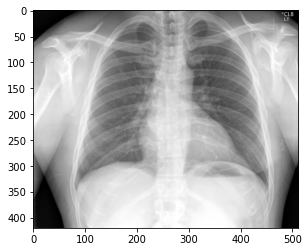

In [58]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
   if i=="<unk>":
      caption.remove(i)

for i in real_caption:
   if i=="<unk>":
      real_caption.remove(i)

result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

BLEU-1 score: 8.686936693348038
BLEU-2 score: 28.81130958940607
BLEU-3 score: 46.5416243125024
BLEU-4 score: 52.47001283601749
Real Caption: tspine osteophytes calcified costochondral cartilages loss disc midthoracic vertebral body streaky opacities lung bases may represent atelectasis scarring no pneumothorax heart borderline enlarged
Predicted Caption: lungs clear bilaterally specifically no evidence focal consolidation pneumothorax pleural effusion cardio mediastinal silhouette unremarkable visualized osseous structures thorax without acute abnormality


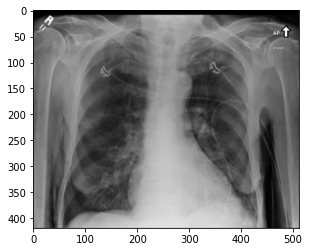

In [62]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
   if i=="<unk>":
      caption.remove(i)

for i in real_caption:
   if i=="<unk>":
      real_caption.remove(i)

result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

#BURA SON TRANSFORMER